In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gsw
import xarray as xr
import toolbox

import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob
import matplotlib

In [3]:
shp_dict = {}
files = glob('../data/ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei

depths = [d for d in shp_dict.keys()][::-1]
colors = sns.mpl_palette('cmo.ice_r', n_colors=8)
cmap   = sns.mpl_palette('cmo.ice', n_colors=8, as_cmap=True)

# 5173

In [4]:
sim = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_5179m_t3650_diff-False.nc')
# sim = xr.load_dataset('../data/simulations/SA_5179m_t3650_diff-False.nc')
sim5170 = toolbox.stuck_particles_mask(sim)

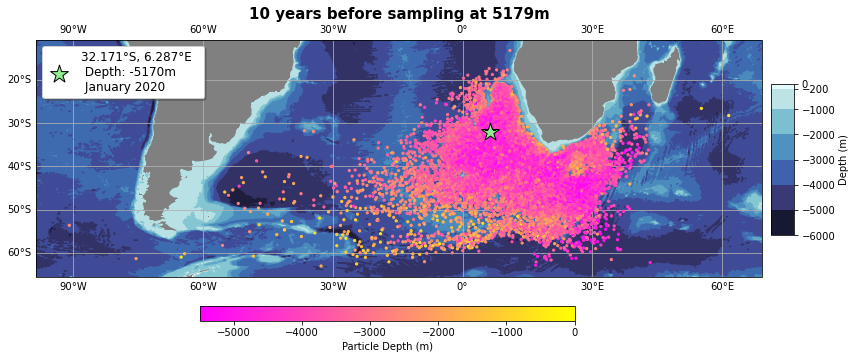

In [153]:
max_depth = -5500
min_depth = 0 

fig = plt.figure(figsize=(13,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((-5, 20, -40, -25), crs=ccrs.PlateCarree())


i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.910,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: -5170m \n January 2020', 
           s=350,
          edgecolors='black')

ax.legend(loc='upper left', shadow=True, fontsize=10)
    
im = ax.scatter(sim5170['lon'][:,-1], sim5170['lat'][:,-1], zorder=4, 
           c=-sim5170['z'][:,-1], s=5, cmap='spring', vmax=max_depth, vmin=min_depth)
ax.legend(loc='upper left', shadow=True, fontsize=12)

bar_ax = fig.add_axes([0.3, 0.18, 0.4, 0.03])
fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle Depth (m)')
ax.set_title('10 years before sampling at 5179m', fontsize=15, weight='bold')
plt.savefig('../figs/5170m_passive.png')

# 60m 

In [6]:
sim = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_SA/SA_60m_t3650_diff-False.nc')
sim60 = toolbox.stuck_particles_mask(sim)

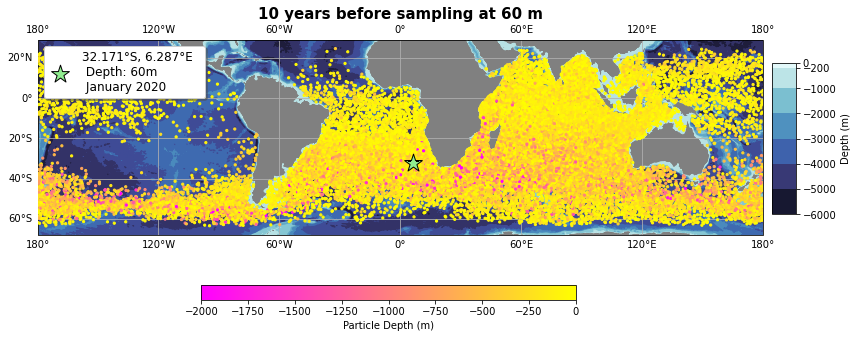

In [152]:
max_depth = -2000
min_depth = 0

age = -1

fig = plt.figure(figsize=(13,7))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent((-5, 20, -40, -25), crs=ccrs.PlateCarree())


i = 0
for depth in depths[:8]:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1

ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='land',scale='110m'),color='grey',
              zorder=0)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False

# Add custom colorbar
axi = fig.add_axes([0.910,0.35,0.025,0.3])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-6000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths[:8]).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

ax.scatter(6.287, -32.171, marker='*',
           zorder=5, color='lightgreen', 
           label='32.171°S, 6.287°E  \n Depth: 60m \n January 2020', 
           s=350,
          edgecolors='black')

ax.legend(loc='upper left', shadow=True, fontsize=10)
    
im = ax.scatter(sim60['lon'][:,age], sim60['lat'][:,age], zorder=4, 
           c=-sim60['z'][:,age], s=5, cmap='spring', vmax=max_depth, vmin=min_depth)
ax.legend(loc='upper left', shadow=True, fontsize=12)

bar_ax = fig.add_axes([0.3, 0.18, 0.4, 0.03])
fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Particle Depth (m)')
ax.set_title('10 years before sampling at 60 m', fontsize=15, weight='bold')
plt.savefig('../figs/60m_passive.png')

# trajectories

In [8]:
sampling_loc = (-32.171, 6.287)

In [9]:
def displacement_from_point(point_A, lons, lats):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.
    """
    lat1, lon1 = point_A
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lons, lats])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [10]:
# displacement60 = displacement_from_point(sampling_loc, sim60['lon'], sim60['lat'])
displacement5170 = displacement_from_point(sampling_loc, sim5170['lon'], sim5170['lat'])

In [11]:
def average_parcels_output(array, window=30):
    nx, nt = array.shape

    new_t_dim = nt//window
    averaged = np.zeros((nx, new_t_dim, ))
    time_array = np.array(range(1, new_t_dim))

    for t in range(0, new_t_dim):
        index_slice = slice((t)*window, (t+1)*window)
        mean_aux = np.mean(array[:, index_slice], axis=1)
        averaged[:, t] = mean_aux

    return averaged

In [12]:
# mean_displ_60 = average_parcels_output(displacement60, window=365)
mean_displ_5170 = average_parcels_output(displacement5170, window=365)

In [13]:
mean_displ_5170

array([[ 479.59287788,  463.63815056,  204.51033184, ...,  408.96401103,
         685.87382094,  697.74883372],
       [ 264.77326796,  428.48894485,  901.29927521, ...,  788.97797877,
         899.94716682,           nan],
       [ 282.49464583,  854.73305362,  831.39255666, ..., 1896.15803379,
        1985.48056061, 1935.23193824],
       ...,
       [ 264.08403787,  406.57135913,  242.06553689, ...,  824.2398638 ,
         886.20788489,  666.74755324],
       [ 302.81865806,  473.08209866,  595.428205  , ...,           nan,
                  nan,           nan],
       [ 530.51990384,  774.23277963,  847.44635497, ...,  289.75324772,
         462.69850282,  573.22087366]])

(array([4.957e+03, 8.560e+03, 7.599e+03, 5.498e+03, 2.766e+03, 2.931e+03,
        2.717e+03, 1.399e+03, 1.370e+03, 1.483e+03, 1.062e+03, 3.980e+02,
        1.680e+02, 6.800e+01, 3.300e+01, 1.600e+01, 7.000e+00, 5.000e+00,
        4.000e+00, 6.000e+00, 6.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 114.87620621,  355.38643392,  595.89666162,  836.40688933,
        1076.91711704, 1317.42734474, 1557.93757245, 1798.44780016,
        2038.95802786, 2279.46825557, 2519.97848328, 2760.48871098,
        3000.99893869, 3241.50916639, 3482.0193941 , 3722.52962181,
        3963.03984951, 4203.55007722, 4444.06030493, 4684.57053263,
        4925.08076034, 5165.59098805, 5406.10121575, 5646.61144346,
        5887.12167116, 6127.63189887, 6368.14212658, 6608.65235428,
        6849.16258199, 7089.6728097 , 7330.1830374 ]),
 <BarContainer object of 30 artists>)

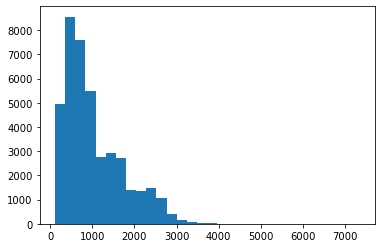

In [14]:
age = 9
# plt.hist(mean_displ_60[:,age], bins=30)
plt.hist(mean_displ_5170[:,age], bins=30)

(array([2.609e+03, 6.952e+03, 7.880e+03, 7.287e+03, 3.965e+03, 2.491e+03,
        2.917e+03, 2.078e+03, 1.099e+03, 1.368e+03, 1.285e+03, 7.070e+02,
        2.200e+02, 1.160e+02, 3.800e+01, 1.700e+01, 7.000e+00, 5.000e+00,
        3.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.34474114e+00, 2.40622835e+02, 4.77900928e+02, 7.15179022e+02,
        9.52457116e+02, 1.18973521e+03, 1.42701330e+03, 1.66429140e+03,
        1.90156949e+03, 2.13884758e+03, 2.37612568e+03, 2.61340377e+03,
        2.85068187e+03, 3.08795996e+03, 3.32523805e+03, 3.56251615e+03,
        3.79979424e+03, 4.03707233e+03, 4.27435043e+03, 4.51162852e+03,
        4.74890661e+03, 4.98618471e+03, 5.22346280e+03, 5.46074090e+03,
        5.69801899e+03, 5.93529708e+03, 6.17257518e+03, 6.40985327e+03,
        6.64713136e+03, 6.88440946e+03, 7.12168755e+03]),
 <BarContainer object of 30 artists>)

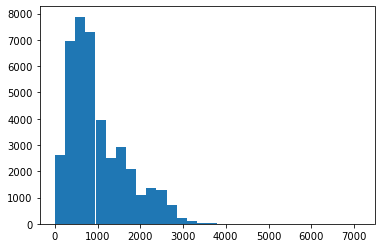

In [15]:
age = 365*9
plt.hist(displacement5170[:,age], bins=30)

In [17]:
def haversine_trajectory_steps(lon, lat):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.
    """
    lon, lat = map(np.radians, [lon, lat])
    
    lon1, lon0 = np.roll(lon, 0, axis=1), np.roll(lon, 1, axis=1)
    lat1, lat0 = np.roll(lat, 0, axis=1), np.roll(lat, 1, axis=1)
    
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    
    dlon[:,0] = np.zeros(lon.shape[0])
    dlat[:,0] = np.zeros(lon.shape[0])

    a = np.sin(dlat/2.0)**2 + np.cos(lat0) * np.cos(lat1) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    
    return km

In [132]:
def trajectory_from_steps(steps):
    
    for i in range(1, steps.shape[1]):
        j = i-2

        steps[:, j+1] = np.sum(steps[:,j:i], axis=1)
    
    steps[:, -1] = steps[:, -2] + steps[:, -1]
    return steps

In [137]:
trajectory5170 = haversine_trajectory_steps(sim5170['lon'], sim5170['lat'])

In [140]:
traj5170 = trajectory_from_steps(trajectory5170)

In [142]:
traj5170

array([[0.00000000e+00, 6.26624200e+00, 1.74718660e+01, ...,
        4.63922361e+07, 4.64143211e+07, 4.64364145e+07],
       [0.00000000e+00, 6.75912118e+00, 1.97188390e+01, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 6.51590214e+00, 1.96883162e+01, ...,
        2.85627608e+07, 2.85806027e+07, 2.85984493e+07],
       ...,
       [0.00000000e+00, 6.52382207e+00, 1.95448327e+01, ...,
        3.37556788e+07, 3.37730717e+07, 3.37904718e+07],
       [0.00000000e+00, 6.57442072e+00, 1.92472785e+01, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 6.82300326e+00, 1.99100487e+01, ...,
        5.40750045e+07, 5.40998000e+07, 5.41245976e+07]])

In [149]:
non_dist = displacement5170[:,1:]/traj5170[:, 1:]

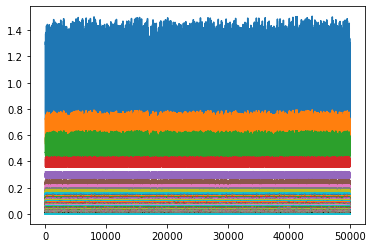

In [151]:
plt.plot(non_dist[:,:]);
# plt.plot(non_dist[1,:])

In [26]:
displacement5170[0,-1]/sum(trajectory5170[0,:])

<xarray.DataArray ()>
array(0.02581422)

# T-S diagrams

In [3]:
def TS_diagram(dataset, figsize=(8,8)):
    max_sal, min_sal = dataset['abs_salinity'].max(), dataset['abs_salinity'].min()
    max_temp, min_temp = dataset['cons_temperature'].max(), dataset['cons_temperature'].min()

    tempL = np.linspace(min_temp - 1, max_temp + 1, 156)
    salL = np.linspace(min_sal - 1, max_sal + 1, 156)
    Tg, Sg = np.meshgrid(tempL,salL)

    sigma_theta = gsw.sigma0(Sg, Tg)
    cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

    fig, ax = plt.subplots(figsize=(6,6))

    # for i in range(1000
    plt.scatter(dataset['abs_salinity'][1:, :], dataset['cons_temperature'][1:, :], s=1, color='darkcyan');
    plt.scatter(dataset['abs_salinity'][0,1], dataset['cons_temperature'][0, 1], s=5, color='red')

    cs = ax.contour(Sg, Tg, sigma_theta, colors='k', zorder=1)
    cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')

    ax.set_xlabel('Absolute Salinity ($‰$)')
    ax.set_ylabel('Conservative Temperature[$^\circ$C]')

    ax.tick_params(direction='out')
    ax.set_xlim(min_sal - 1, max_sal + 1)
    plt.tight_layout()
    
    return fig, ax


In [9]:
sim = xr.load_dataset('../data/simulations/SA_5179m_t3650_diff-False.nc')

In [10]:
sim2 = toolbox.stuck_particles_mask(sim)

In [14]:
sim2

<xarray.Dataset>
Dimensions:           (obs: 3651, traj: 50000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 5e+04 5e+04 5e+04
    time              (traj, obs) datetime64[ns] 2019-12-30T12:00:00 ... 2010...
    lat               (traj, obs) float64 -32.15 -32.12 -32.08 ... -33.73 -33.74
    lon               (traj, obs) float64 6.295 6.353 6.37 ... -0.2144 -0.2338
    z                 (traj, obs) float64 5.179e+03 5.185e+03 ... 4.293e+03
    cons_temperature  (traj, obs) float32 0.7166 0.7281 0.7275 ... 0.7073 0.7133
    abs_salinity      (traj, obs) float32 34.74 34.74 34.74 ... 34.74 34.74
    mld               (traj, obs) float32 33.11 50.49 50.82 ... 17.87 10.74
    alpha             (traj, obs) float32 1e-06 1e-06 1e-06 ... 1e-06 1e-06
    density           (traj, obs) float32 1.035e+03 1.028e+03 ... 1.028e+03
    v_s               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

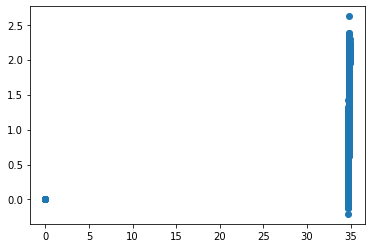

In [23]:
N = 1000
plt.scatter(sim['abs_salinity'][:, N], sim['cons_temperature'][:, N])

(array([ 9418.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0., 40582.]),
 array([ 0.       ,  1.1644226,  2.3288453,  3.4932678,  4.6576905,
         5.822113 ,  6.9865355,  8.150958 ,  9.315381 , 10.479803 ,
        11.644226 , 12.808649 , 13.973071 , 15.137494 , 16.301916 ,
        17.46634  , 18.630762 , 19.795185 , 20.959606 , 22.12403  ,
        23.288452 , 24.452875 , 25.617298 , 26.78172  , 27.946142 ,
        29.110565 , 30.274988 , 31.439411 , 32.603832 , 33.768257 ,
        34.93268  ], dtype=float32),
 <BarContainer object of 30 artists>)

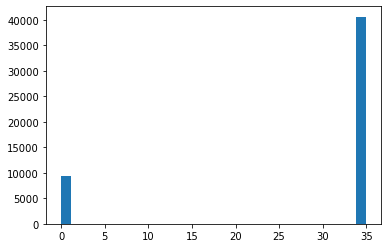

In [28]:
N = 3600
plt.hist(sim['abs_salinity'][:, N], bins=30)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5311e+04]),
 array([ 0.       ,  1.163305 ,  2.32661  ,  3.4899151,  4.65322  ,
         5.816525 ,  6.9798303,  8.143135 ,  9.30644  , 10.469746 ,
        11.63305  , 12.796355 , 13.959661 , 15.122966 , 16.28627  ,
        17.449575 , 18.61288  , 19.776186 , 20.939491 , 22.102795 ,
        23.2661   , 24.429405 , 25.59271  , 26.756016 , 27.919321 ,
        29.082626 , 30.245932 , 31.409235 , 32.57254  , 33.735847 ,
        34.89915  ], dtype=float32),
 <BarContainer object of 30 artists>)

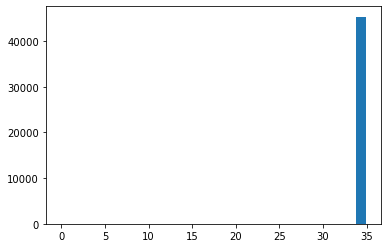

In [29]:
N = 1000
plt.hist(sim2['abs_salinity'][:, N], bins=30)

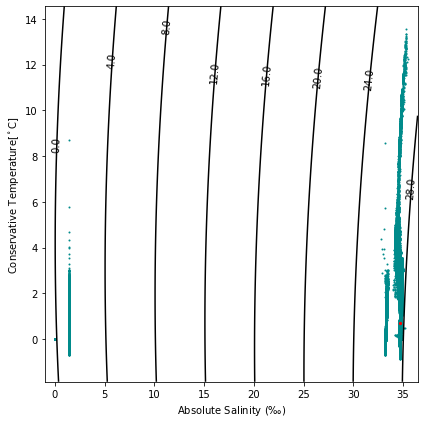

In [12]:
fig, ax = TS_diagram(sim)

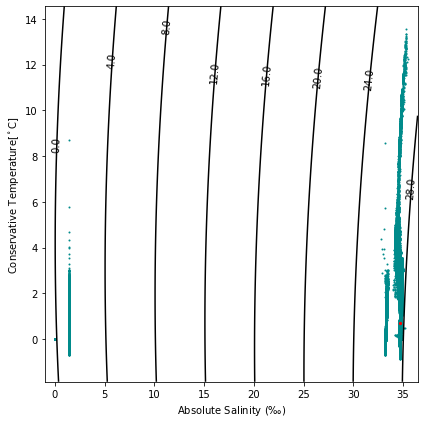

In [13]:
fig, ax = TS_diagram(sim2)

In [ ]:
tempL = np.linspace(1-1, 10+1, 156)

salL = np.linspace(30-1, 36+1, 156)

Tg, Sg = np.meshgrid(tempL, salL)
sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(), 156)

fig, ax = plt.subplots(figsize=(4,6))
cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
cl = plt.clabel(cs, fontsize=10, inline=False, fmt='%.1f')

sc = plt.scatter(sim['salinity'][:, 6], sim['temperature'][:, 6], s=10)
cb = plt.colorbar(sc)

ax.set_xlabel('Salinity ($‰$)')
ax.set_ylabel('Temperature[$^\circ$C]')
ax.set_title('General T-S (Temperature and salinity) Diagram',fontsize=14, fontweight='bold')
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.tick_params(direction='out')
